In [1]:
import pandas as pd
import numpy as np

import surprise
from surprise import NormalPredictor
from surprise import SVD
from surprise import SlopeOne
from surprise import Dataset
#from surprise import DatasetAutoFolds
from surprise import Reader
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, BaselineOnly, CoClustering, SVD, SVDpp

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as rmse
from sklearn import pipeline

import knn_features
import nltk

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

# set random state for reproducibility
kwargs = dict(random_state=42)

Documentary of scikit-suprise can be found under https://surprise.readthedocs.io/en/stable/

In [2]:
ratings = pd.read_csv('../data/preprocessed/ratings_clean_std_0.csv', sep=',').drop(columns={'Unnamed: 0'})
omdb = pd.read_csv('../data/preprocessed/omdb_cleaned.csv')

In [3]:
#delete ratings of movie "nomads" until last model
ratings = ratings[ratings['imdbID']!='tt0720339']

In [4]:
ratings.reset_index(inplace=True, drop=True)

In [5]:
ratings

,user_id,imdbID,rating
0,1264,tt0047034,3.5
1,213,tt0304141,2.5
2,593,tt0369436,3.0
3,609,tt1077258,4.0
4,1590,tt0052182,4.0
...,...,...,...
787531,1032,tt0083530,3.0
787532,99,tt0107798,3.0
787533,333,tt0093857,3.0
787534,49,tt0144168,3.0


In [6]:
# build a reader, define the rating scale (minimum and maximum value)
reader = Reader(rating_scale=(0.5, 5))

In [7]:
#Use optimal k based on # rated movies
def adjust_k(ratings_k):
    adjusted_k = 10
    r_size = len(ratings_k)
  
    if 40 < r_size < 100:
        adjusted_k = 15
    elif 100 < r_size < 500:
        adjusted_k = 20
    elif 500 < r_size < 1500:
        adjusted_k = 25
    elif r_size  > 1500:
        adjusted_k = 30

    return adjusted_k

In [8]:
# function that computes a rating based on the neighbors
def compute_rating(neighbors, distances, mean):
    if mean:
        # Mittelwert der k-nächsten Nachbarn
        pred = neighbors.mean()
    else:
        # Gewichtung der Bewertung der Nachbarn je nach Distanz
        pred = sum(neighbors*((1/(distances[0]+0.000001)**1)/(sum((1/(distances[0]+0.000001)**1)))))

    return float(pred)

In [9]:
## function that predicts the rating of a movie from its imdbID and its nearest neighbors
def predict_movie_rating(imdbID, ratings, feature_data, mean, knn_metric, set_k, k_neighbors=10):
    
    #If no explicit number of neighbors is passed -> use variable neighbors function
    if set_k:
        k_neighbors = k_neighbors
    else:    
        k_neighbors = adjust_k(ratings)

  
    # Get real rating -> remove this in the end -> currently done for validation
    #real_ratings = ratings.loc[(ratings['imdbID'] == imdbID)]
    real_idx = ratings.loc[(ratings['imdbID'] == imdbID)].index
    
    #remove real rating for training
    ratings = ratings[ratings['imdbID'] != imdbID] 
    
    # Set algorithm and params
    knn = NearestNeighbors(metric=knn_metric, algorithm='brute', n_neighbors=k_neighbors, n_jobs=-1)
    
    #Select features rated by user for training
    feat = feature_data[ratings['imdbID'].index]

    ratings.reset_index(inplace=True, drop=False)
    
    #train algorithm
    knn.fit(feat)

    #generate input data
    input_data = feature_data[real_idx]
    input_data = input_data.reshape(1, -1)

    #Prediction -> get x nearest neighbors of imdbID
    distances, indices = knn.kneighbors(input_data, n_neighbors=k_neighbors)

    # Zieht indices und ratings der neighbors
    neighbor_ratings = ratings['rating'].loc[indices[0]]

    #Calculate rating
    pred = compute_rating(neighbor_ratings, distances, mean)

    return pred

In [15]:
# function that finds optimal fixed weights for several models
def compare_weights(algos, params_features, params_knn):
    i=0
    rmses = []
    predictions = []
    number_of_ratings = []
    actual_ratings = []
    for train, test in KFold(n_splits=1000, **kwargs, shuffle=True).split(ratings):
        # split data
        trainset = ratings.loc[train]
        testset = ratings.loc[test]
        
        # convert data to surprise format
        train_surprise = Dataset.load_from_df(trainset, reader).build_full_trainset()
        test_surprise = Dataset.load_from_df(testset, reader).build_full_trainset().build_testset()       
        
        # overwrite testset as surprise sorts entries
        testset = pd.DataFrame(test_surprise).rename(columns={0:'user_id', 1:'imdbID', 2:'rating'})        
        
        preds = []
        # Collaborative Filtering Models
        for algo in algos:
            algo.fit(train_surprise)
            preds.append([algo.predict(uid, iid).est for uid, iid,_ in test_surprise])
    
        # Content-Based Models
        # load features
        features, names = knn_features.features(**params_features)
        # add imdbID and set as index
        features = omdb[['imdbID']].join(pd.DataFrame(features)).set_index('imdbID')
        
        # predict ratings
        pred_content = []
        no_of_ratings = []
        for row in testset.itertuples():
            # select user and movie
            imdbID = row.imdbID
            userID = row.user_id
            # select ratings of the user
            ratings_user = ratings.loc[ratings['user_id'] == userID]
            ratings_user.reset_index(inplace=True, drop=True)

            # select features of corresponding movies and convert to array
            features_user = np.array(features.loc[ratings_user['imdbID']])

            # compute predictions
            pred_content.append(predict_movie_rating(imdbID, ratings_user, features_user, **params_knn))
            # store the number of predictions of a user:
            no_of_ratings.append(ratings_user.shape[0])
        
        # predictions of the models
        preds_total = [preds[0], preds[1], pred_content]
        preds_total = np.asarray(preds_total)
        
        actuals = np.asarray(testset['rating'])

        # store predictions and real ratings
        predictions.append(preds_total)
        actual_ratings.append(actuals)
        number_of_ratings.append(no_of_ratings)
        
        # calculate rmses
        rmses.append([rmse(actuals, (preds_total[0]*(w1/100)+preds_total[1]*(w2/100)+preds_total[2]*(1-w1/100-w2/100)), squared=False) for w1 in range(0,101) for w2 in range(0, 101-w1)])
        i+=1
        print('Iteration finished: ',i)
        # Early stopping to allow for fast testing
        # may be increased for more stability of the results
        if i == 5:
            return rmses, predictions, actual_ratings, number_of_ratings           

In [16]:
# define collaborative filtering models: KNN and SVD
algos = (KNNWithMeans(k=115, min_k=5, sim_options={'name':'msd', 'user_based': False}, **kwargs), SVD(lr_all=0.01, reg_all=0.05, n_epochs=23, **kwargs))

In [17]:
# define features for content-based models
params_f = {'threshold_actors': 0, 'ts_languages': 0 , 'year': True, 'runtime': True, 'imdbVotes': True, 'series': False, 'awards': False,'genres': True, 'imdb_rating': True, 'roto_rating': False, 'pg_rating':True, 'threshold_newkeywords': 0, 'threshold_plots': 0, 'threshold_directors': 200}

In [18]:
# set the possible parameters for the kNN
params_k = {'mean':False, 'knn_metric':'cosine', 'set_k':False}

In [19]:
# get information on the prediction models
rmses, predictions, actual_ratings, number_of_ratings  = compare_weights(algos, params_f, params_k)

Computing the msd similarity matrix...
Done computing similarity matrix.
Iteration finished:  1
Computing the msd similarity matrix...
Done computing similarity matrix.
Iteration finished:  2
Computing the msd similarity matrix...
Done computing similarity matrix.
Iteration finished:  3
Computing the msd similarity matrix...
Done computing similarity matrix.
Iteration finished:  4
Computing the msd similarity matrix...
Done computing similarity matrix.
Iteration finished:  5


In [49]:
# merge weights and resulting rmses
weights = []
weights.append([(w1/100, w2/100, 1-w1/100-w2/100) for w1 in range(0,101) for w2 in range(0, 101-w1)])
results = pd.DataFrame(np.asarray(weights)[0])
results['rmse'] = res[0]

In [77]:
results.sort_values('rmse')

,0,1,2,rmse
83,0.00,0.83,0.17,0.749751
82,0.00,0.82,0.18,0.749757
183,0.01,0.82,0.17,0.749758
182,0.01,0.81,0.18,0.749766
84,0.00,0.84,0.16,0.749771
...,...,...,...,...
102,0.01,0.01,0.98,0.834647
201,0.02,0.00,0.98,0.834792
1,0.00,0.01,0.99,0.836511
101,0.01,0.00,0.99,0.836651


In [106]:
# get predictions of the models for the first iteration
predictions_0 = pd.DataFrame(preds[0].T)
predictions_0['no_of_ratings'] = np.asarray(numbers)[0]
predictions_0['actual_rating'] = actual_ratings[0]

In [107]:
predictions_0

,0,1,2,no_of_ratings,actual_rating
0,2.267792,2.387882,2.472547,1114,2.0
1,2.347515,2.426420,3.121195,1114,3.0
2,3.104286,3.323229,3.178519,584,3.0
3,3.671640,3.932565,4.267466,274,4.5
4,2.600795,2.667713,3.602758,884,3.0
...,...,...,...,...,...
783,4.346565,4.110952,4.652272,554,5.0
784,3.994729,3.967933,3.589638,1130,4.0
785,2.401547,2.644883,3.025585,21,1.5
786,4.196969,4.207941,3.820243,1561,5.0


# Evaluate different weights for different user types

In [108]:
many = predictions_0.loc[predictions_0['no_of_ratings']>500]

In [109]:
few = predictions_0.loc[predictions_0['no_of_ratings']<=500]

In [111]:
many

,0,1,2,no_of_ratings,actual_rating
0,2.267792,2.387882,2.472547,1114,2.0
1,2.347515,2.426420,3.121195,1114,3.0
2,3.104286,3.323229,3.178519,584,3.0
4,2.600795,2.667713,3.602758,884,3.0
5,3.826060,4.008975,4.170820,884,5.0
...,...,...,...,...,...
781,3.884974,3.631360,3.492199,874,4.0
783,4.346565,4.110952,4.652272,554,5.0
784,3.994729,3.967933,3.589638,1130,4.0
786,4.196969,4.207941,3.820243,1561,5.0


In [113]:
many['actual_rating']

0      2.0
1      3.0
2      3.0
4      3.0
5      5.0
      ... 
781    4.0
783    5.0
784    4.0
786    5.0
787    3.5
Name: actual_rating, Length: 490, dtype: float64

In [116]:
many_rmse = pd.DataFrame([rmse(many['actual_rating'], (many.loc[:,0]*(w1/100)+many.loc[:,1]*(w2/100)+many.loc[:,2]*(1-w1/100-w2/100)), squared=False) for w1 in range(0,101) for w2 in range(0, 101-w1)])

In [117]:
few_rmse = pd.DataFrame([rmse(few['actual_rating'], (few.loc[:,0]*(w1/100)+few.loc[:,1]*(w2/100)+few.loc[:,2]*(1-w1/100-w2/100)), squared=False) for w1 in range(0,101) for w2 in range(0, 101-w1)])

In [119]:
many_1 = pd.DataFrame(np.asarray(weights)[0])
many_1['rmse'] = many_rmse

In [120]:
few_1 = pd.DataFrame(np.asarray(weights)[0])
few_1['rmse'] = few_rmse

In [121]:
many_1.sort_values('rmse')

,0,1,2,rmse
1971,0.21,0.60,0.19,0.775107
1891,0.20,0.61,0.19,0.775109
2050,0.22,0.59,0.19,0.775111
1972,0.21,0.61,0.18,0.775116
1810,0.19,0.62,0.19,0.775117
...,...,...,...,...
102,0.01,0.01,0.98,0.853467
201,0.02,0.00,0.98,0.853486
1,0.00,0.01,0.99,0.855355
101,0.01,0.00,0.99,0.855370


In [122]:
few_1.sort_values('rmse')

,0,1,2,rmse
88,0.00,0.88,0.12,0.703306
87,0.00,0.87,0.13,0.703308
89,0.00,0.89,0.11,0.703333
86,0.00,0.86,0.14,0.703339
90,0.00,0.90,0.10,0.703388
...,...,...,...,...
102,0.01,0.01,0.98,0.802743
201,0.02,0.00,0.98,0.803108
1,0.00,0.01,0.99,0.804566
101,0.01,0.00,0.99,0.804926


Try 3D-Plot

In [72]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [73]:
results_3d = results[[0,1,'rmse']].pivot(index=0, columns=1, values='rmse')

In [74]:
results_3d.values.shape

(101, 101)

<ipython-input-75-db39752d5675>:5: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax.plot_surface(results_3d.index.values, results_3d.columns.values, results_3d.values, cmap=cm.coolwarm, linewidth=0, antialiased=False)


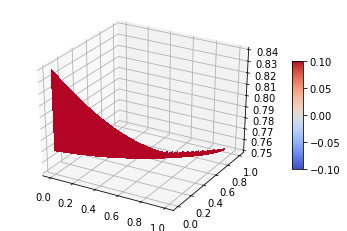

In [75]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_surface(results_3d.index.values, results_3d.columns.values, results_3d.values, cmap=cm.coolwarm, linewidth=0, antialiased=False)
# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)

plt.show()